In [78]:
%matplotlib inline

In [12]:
# pip install "qiskit>=1.0" "qiskit-aer>=0.15"

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np

# ----- Data layout (row-major) -----
# d0 d1 d2
# d3 d4 d5
# d6 d7 d8

X_checks = [
    [0,1,3,4],   # X_TL
    [4,5,7,8],   # X_BR
    [1,2],       # X_top border
    [6,7],       # X_bottom border
]

# Z checks you will MEASURE in Sub-round A (note the two halves)
Z_checks_meas = [
    [3,4,6,7],   # Z0 (bottom-left face)
    [1,4],       # Z-half A (super)
    [2,5],       # Z-half B (super)
    [0,3],       # Z_left border
    [5,8],       # Z_right border
]

# For DECODING, you'll use the reconstructed "old" top-right face [1,2,4,5]
Z_checks_decode = [
    [3,4,6,7],   # Z0 (bottom-left)
    [1,2,4,5],   # Z_top-right (old) = XOR(Z(1,4), Z(2,5))
    [0,3],       # Z_left
    [5,8],       # Z_right
]

n_data = 9
n_z_meas = len(Z_checks_meas)  # 5
n_x = len(X_checks)   

def combine_super_syndromes_Z(mz_meas_bits):
    """
    Input: mz_meas_bits length-5 in the order of Z_checks_meas:
           [ Z0, Z(1,4), Z(2,5), Z_left, Z_right ]
    Output: mz_eff length-4 in the order of Z_checks_decode:
            [ Z0, Z_top-right_old, Z_left, Z_right ],
            where Z_top-right_old = Z(1,4) XOR Z(2,5).
    """
    mz_meas_bits = np.asarray(mz_meas_bits, dtype=np.uint8).ravel()
    Z0, Z14, Z25, ZL, ZR = mz_meas_bits
    Z_old = Z14 ^ Z25
    return np.array([Z0, Z_old, ZL, ZR], dtype=np.uint8)


def build_two_subround_circuit():
    q_data = QuantumRegister(n_data, "d")
    q_az   = QuantumRegister(n_z_meas, "az")  # Z ancillas for Sub-round A
    q_ax   = QuantumRegister(n_x, "ax")       # X ancillas for Sub-round B

    # Put Z classical first, then X classical
    # (Qiskit prints the *last* classical register on the LEFT of the bitstring)
    c_z    = ClassicalRegister(n_z_meas, "mz_meas")
    c_x    = ClassicalRegister(n_x, "mx")
    qc = QuantumCircuit(q_data, q_az, q_ax, c_z, c_x, name="d3_superZ_then_X")

    # --- SUB-ROUND A: Z-only (commuting) ---
    for a_idx, ds in enumerate(Z_checks_meas):
        az = q_az[a_idx]
        qc.reset(az)                 # |0>
        for qd in ds:                # CNOT data -> ancilla
            qc.cx(q_data[qd], az)
        qc.measure(az, c_z[a_idx])

    qc.barrier()

    # --- SUB-ROUND B: X-only (commuting) ---
    for a_idx, ds in enumerate(X_checks):
        ax = q_ax[a_idx]
        qc.reset(ax)
        qc.h(ax)                     # |+>
        for qd in ds:                # CNOT ancilla -> data
            qc.cx(ax, q_data[qd])
        qc.h(ax)
        qc.measure(ax, c_x[a_idx])

    return qc



In [13]:

def run_and_extract_syndromes(qc, shots=1, backend=None):
    # ----- Run on Aer simulator -----
    if backend is None:
        backend = AerSimulator()
    backend = AerSimulator()
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=1000).result()
    counts = res.get_counts(tqc)

    # Take one representative shot (for multi-shot, iterate similarly)
    key = next(iter(counts))  # e.g. "1101 01010"
    # Split: left is mx, right is mz_meas (because c_x was added after c_z)
    print(key)
    mx_str, mz_meas_str = key.split()

    # Convert strings to little-endian numpy arrays (index 0 = first check in our lists)
    mx_bits      = np.fromiter(map(int, mx_str[::-1]), dtype=np.uint8, count=len(mx_str))
    mz_meas_bits = np.fromiter(map(int, mz_meas_str[::-1]), dtype=np.uint8, count=len(mz_meas_str))

    # Combine halves into the old weight-4 Z face for decoding
    mz_eff = combine_super_syndromes_Z(mz_meas_bits)

    return mx_bits, mz_eff, mz_meas_bits, counts
    # print("\nSyndrome (mx[0..3] mz[0..3]) counts:")
    # for k, v in sorted(counts.items(), key=lambda kv: -kv[1]):
    #     print(k, v)

In [14]:
qc = build_two_subround_circuit()
mx, mz_eff, mz_meas, counts = run_and_extract_syndromes(qc, shots=1000)

print("Raw Z (measured order)  mz_meas =", mz_meas.tolist(), "  (order: [Z0, Z(1,4), Z(2,5), Z_left, Z_right])")
print("Effective Z (for dec)   mz_eff  =", mz_eff.tolist(),  "  (order: [Z0, Z_old, Z_left, Z_right])")
print("X syndrome              mx      =", mx.tolist(),      "  (order: [X_TL, X_BR, X_top, X_bottom])")

1100 00000
Raw Z (measured order)  mz_meas = [0, 0, 0, 0, 0]   (order: [Z0, Z(1,4), Z(2,5), Z_left, Z_right])
Effective Z (for dec)   mz_eff  = [0, 0, 0, 0]   (order: [Z0, Z_old, Z_left, Z_right])
X syndrome              mx      = [0, 0, 1, 1]   (order: [X_TL, X_BR, X_top, X_bottom])


In [15]:

# ----- Helper: quick commutation sanity check (X vs Z overlaps must be even) -----
# def commute_ok(x_checks, z_checks):
#     bad = []
#     for i, xs in enumerate(x_checks):
#         xs_set = set(xs)
#         for j, zs in enumerate(z_checks):
#             if (len(xs_set.intersection(zs)) % 2) == 1:
#                 bad.append((i, j, xs, zs))
#     return bad

# violations = commute_ok(X_checks, Z_checks)
# assert len(violations) == 0, f"Found noncommuting pairs: {violations}"

# ----- Try an error injection to see border syndromes fire -----
def run_with_error(q_err=None, pauli="X", shots=1000, backend=None,
                   do_decode=False, dec_X=None, dec_Z=None,
                   X_L_support=None, Z_L_support=None):
    """
    Builds the two-sub-round circuit, optionally injects a Pauli on a data qubit,
    runs it, parses:
      - mx       : X-check outcomes (len = len(X_checks))
      - mz_meas  : raw Z outcomes in measured order (len = len(Z_checks_meas))
      - mz_eff   : reconstructed Z outcomes for the decoder (len = len(Z_checks_decode))
    If do_decode=True, also:
      - x_hat, z_hat : PyMatching estimates over data qubits
      - residual rx, rz
      - logical flags logical_X, logical_Z (needs X_L_support, Z_L_support)
    Returns a dict with all of the above plus 'counts'.
    """
    if backend is None:
        backend = AerSimulator()

    # Build base circuit
    qc = build_two_subround_circuit()

    # Inject an error on the chosen data qubit BEFORE sub-round A
    if q_err is not None:
        if pauli.upper() == "X":
            qc.x(qc.qubits[q_err])   # q_data[q_err] is the first register; indexing works as-built
        elif pauli.upper() == "Z":
            qc.z(qc.qubits[q_err])
        elif pauli.upper() == "Y":
            qc.y(qc.qubits[q_err])
        else:
            raise ValueError("pauli must be one of {'X','Y','Z'}")
    
    # Run
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    counts = res.get_counts(tqc)

    # Parse one representative bitstring (for aggregate logic, iterate all keys with their counts)
    key = next(iter(counts))  # looks like "<mx bits> <mz_meas bits>" because c_z added before c_x
    mx_str, mz_meas_str = key.split()

    # Convert to little-endian arrays so index 0 matches our list order
    mx      = np.fromiter(map(int, mx_str[::-1]), dtype=np.uint8, count=len(mx_str))
    mz_meas = np.fromiter(map(int, mz_meas_str[::-1]), dtype=np.uint8, count=len(mz_meas_str))

    # Combine the super Z halves to the old face
    mz_eff = combine_super_syndromes_Z(mz_meas)

    out = dict(mx=mx, mz_meas=mz_meas, mz_eff=mz_eff, counts=counts)

    # Optional decoding
    if do_decode:
        if dec_X is None or dec_Z is None:
            raise ValueError("do_decode=True but dec_X/dec_Z not provided.")
        x_hat = dec_X.decode(mz_eff)  # estimate X errors from effective Z syndrome
        z_hat = dec_Z.decode(mx)      # estimate Z errors from X syndrome
        out.update(x_hat=x_hat, z_hat=z_hat)

        # Optional logical checks if supports provided
        if X_L_support is not None and Z_L_support is not None:
            # Without ground-truth physical errors, define residual = estimates (one-shot correction)
            rx = (x_hat & 1).astype(np.uint8)
            rz = (z_hat & 1).astype(np.uint8)

            def parity_on(vec01, support):
                return int(np.bitwise_xor.reduce(vec01[np.array(support, dtype=int)])) if len(support) else 0

            logical_Z = parity_on(rx, Z_L_support)  # X across Z-logical string
            logical_X = parity_on(rz, X_L_support)  # Z across X-logical string
            out.update(rx=rx, rz=rz, logical_X=logical_X, logical_Z=logical_Z)

    return out

In [17]:
# Matching / decoding cell
# Requires: pip install pymatching numpy

import numpy as np
from pymatching import Matching

def checks_to_H(checks, n_cols):
    """Convert list-of-lists checks into a binary parity matrix H."""
    H = np.zeros((len(checks), n_cols), dtype=np.uint8)
    for i, S in enumerate(checks):
        H[i, S] = 1
    return H

def init_pymatching_decoders(X_checks, Z_checks, n_data):
    """
    Build CSS decoders:
      - dec_Z uses H_X to decode Z errors from X-syndrome (mx)
      - dec_X uses H_Z to decode X errors from Z-syndrome (mz)
    Returns (dec_X, dec_Z, H_X, H_Z).
    """
    H_X = checks_to_H(X_checks, n_data)  # rows: X checks
    H_Z = checks_to_H(Z_checks, n_data)  # rows: Z checks
    dec_Z = Matching(H_X)                # decode Z errors from mx
    dec_X = Matching(H_Z)                # decode X errors from mz
    return dec_X, dec_Z, H_X, H_Z

def decode_x_errors(mz, dec_X):
    """
    Given Z-syndrome 'mz' (uint8 vector), estimate X-error support on data qubits.
    Returns np.ndarray of shape (n_data,) with 0/1 entries.
    """
    mz = np.asarray(mz, dtype=np.uint8).ravel()
    return dec_X.decode(mz)

def decode_z_errors(mx, dec_Z):
    """
    Given X-syndrome 'mx' (uint8 vector), estimate Z-error support on data qubits.
    Returns np.ndarray of shape (n_data,) with 0/1 entries.
    """
    mx = np.asarray(mx, dtype=np.uint8).ravel()
    return dec_Z.decode(mx)

# --- Initialize decoders (call once after your X_checks, Z_checks, n_data are defined) ---
dec_X, dec_Z, H_X, H_Z = init_pymatching_decoders(X_checks, Z_checks_decode, n_data)


In [23]:
# ------- Example quick calls -------
# 1) Just run with an injected X on d4, parse syndromes:
# ex1 = run_with_error(q_err=4, pauli="X", shots=1000)
# print("mx =", ex1["mx"].tolist(), "  mz_eff =", ex1["mz_eff"].tolist())

# 2) Run and decode (requires decoders and logical strings):
# (Assuming you built dec_X from H_Z_decode and dec_Z from H_X, and set supports)
X_L_support = [1,4,7]
Z_L_support = [3,4,5]
ex2 = run_with_error(q_err=6, pauli="Z", shots=1000, do_decode=True,
                     dec_X=dec_X, dec_Z=dec_Z,
                     X_L_support=X_L_support, Z_L_support=Z_L_support)
print("x_hat@", np.where(ex2["x_hat"]==1)[0].tolist(),
      "z_hat@", np.where(ex2["z_hat"]==1)[0].tolist(),
      "logicalX?", ex2["logical_X"], "logicalZ?", ex2["logical_Z"])

x_hat@ [] z_hat@ [4, 6] logicalX? 1 logicalZ? 0


In [34]:

# --- One-shot surface-code error sampling + decoding + logical check ---

# Choose representative logical operators for our boundary choices:
#   - X-type boundaries are TOP/BOTTOM => logical X is any vertical X string
#   - Z-type boundaries are LEFT/RIGHT => logical Z is any horizontal Z string
X_L_support = np.array([1,4,7], dtype=int)  # vertical middle column
Z_L_support = np.array([3,4,5], dtype=int)  # horizontal middle row

def sample_pauli_errors(n, p=0.05, pX=None, pY=None, pZ=None, rng=None):
    """
    IID single-qubit Pauli channel on n data qubits.
    Default: each non-identity with equal prob p/3.
    Returns (x_err, z_err) as 0/1 vectors (Y = X and Z both 1).
    """
    if rng is None:
        rng = np.random.default_rng()
    if pX is None or pY is None or pZ is None:
        pX = pY = pZ = p / 3.0
    probs = np.array([1 - (pX + pY + pZ), pX, pY, pZ])
    # 0=I, 1=X, 2=Y, 3=Z
    choices = rng.choice(4, size=n, p=probs)
    x_err = ((choices == 1) | (choices == 2)).astype(np.uint8)
    z_err = ((choices == 3) | (choices == 2)).astype(np.uint8)
    return x_err, z_err, choices

def parity_on(indices, support):
    """Return parity of a 0/1 vector 'indices' over positions in 'support'."""
    return int(np.bitwise_xor.reduce(indices[support])) if len(support) else 0

def run_one_trial(p=0.05, rng=None, verbose=False):
    # 1) Sample physical Pauli errors (truth)
    x_err, z_err, choices = sample_pauli_errors(n_data, p=p, rng=rng)

    # 2) Compute ideal (perfect-measurement) syndromes
    #    X-syndrome comes from Z errors; Z-syndrome from X errors
    mx = (H_X @ z_err) % 2  # rows = X checks
    mz = (H_Z @ x_err) % 2  # rows = Z checks

    # 3) Decode
    x_hat = dec_X.decode(mz)  # estimate X-error pattern from Z-syndrome
    z_hat = dec_Z.decode(mx)  # estimate Z-error pattern from X-syndrome

    # 4) Residual after correction (what remains on data)
    rx = (x_err ^ x_hat).astype(np.uint8)  # residual X-type
    rz = (z_err ^ z_hat).astype(np.uint8)  # residual Z-type

    # 5) Check for logical errors:
    #    - residual X along Z_L (anticommutes with Z_L) -> logical Z flip
    #    - residual Z along X_L (anticommutes with X_L) -> logical X flip
    logical_Z = parity_on(rx, Z_L_support)
    logical_X = parity_on(rz, X_L_support)

    if verbose:
        def support_str(v): return "[" + ", ".join(map(str, np.where(v==1)[0])) + "]"
        pauli_map = {0:"I",1:"X",2:"Y",3:"Z"}
        truth_labels = [pauli_map[c] for c in choices]
        print("=== One-shot surface-code decode ===")
        print(f"Physical truth (per data qubit 0..8): {truth_labels}")
        print(f"X errors @ {support_str(x_err)}")
        print(f"Z errors @ {support_str(z_err)}")
        print(f"Syndrome mx (X checks): {mx.tolist()}")
        print(f"Syndrome mz (Z checks): {mz.tolist()}")
        print(f"Decoder X-hat @ {support_str(x_hat)}")
        print(f"Decoder Z-hat @ {support_str(z_hat)}")
        print(f"Residual X  @ {support_str(rx)}")
        print(f"Residual Z  @ {support_str(rz)}")
        print(f"Logical X error? {'YES' if logical_X else 'no'}")
        print(f"Logical Z error? {'YES' if logical_Z else 'no'}")

    # return dict(
    #     x_err=x_err, z_err=z_err, mx=mx, mz=mz,
    #     x_hat=x_hat, z_hat=z_hat, rx=rx, rz=rz,
    #     logical_X=logical_X, logical_Z=logical_Z
    # )
    return logical_X, logical_Z



In [35]:
# ---- Run a quick demo trial ----
# _ = run_one_trial(p=0.05, rng=np.random.default_rng(1234), verbose=True)
_ = run_one_trial(p=0.25, rng=None, verbose=True)

=== One-shot surface-code decode ===
Physical truth (per data qubit 0..8): ['Y', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I']
X errors @ [0]
Z errors @ [0]
Syndrome mx (X checks): [1, 0, 0, 0]
Syndrome mz (Z checks): [0, 0, 1, 0]
Decoder X-hat @ [0]
Decoder Z-hat @ [0]
Residual X  @ []
Residual Z  @ []
Logical X error? no
Logical Z error? no


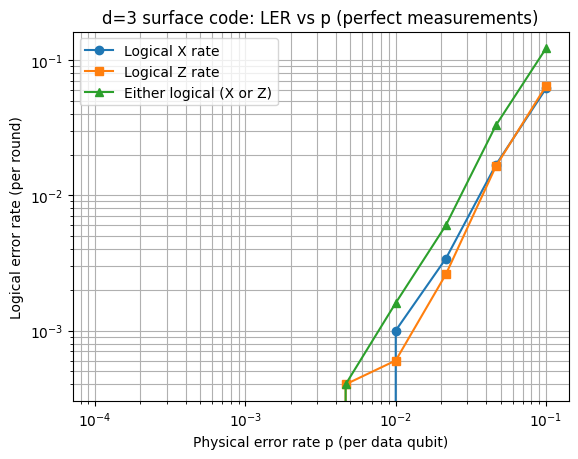

In [43]:
# --- Sweep configuration ---
ps = np.logspace(-4, -1, 10)      # 1e-4 ... 1e-1
trials_per_p = 5000               # bump to ~50k+ for smoother curves
rng = np.random.default_rng(1234)
rng = None

LER_total = []
LER_X = []
LER_Z = []

for p in ps:
    lx = lz = 0
    for _ in range(trials_per_p):
        logical_X, logical_Z = run_one_trial(p, rng)
        lx += logical_X
        lz += logical_Z
    LER_X.append(lx / trials_per_p)
    LER_Z.append(lz / trials_per_p)
    LER_total.append((lx > 0 or lz > 0) / 1)  # not averaged yet

# LER_total as “either logical flip” rate:
LER_total = (np.array(LER_X) + np.array(LER_Z) - np.array(LER_X)*np.array(LER_Z)).tolist()

# --- Plot: LER vs p ---
import matplotlib.pyplot as plt
plt.figure()
plt.loglog(ps, LER_X, marker="o", label="Logical X rate")
plt.loglog(ps, LER_Z, marker="s", label="Logical Z rate")
plt.loglog(ps, LER_total, marker="^", label="Either logical (X or Z)")
plt.xlabel("Physical error rate p (per data qubit)")
plt.ylabel("Logical error rate (per round)")
plt.title("d=3 surface code: LER vs p (perfect measurements)")
plt.legend()
plt.grid(True, which="both")
plt.show()